With ResNet we decompose functions in f(x) = x + g(x), in densenet we do not restrict only to sum but more generally we concatenate outputs.

We perform a mapping from x to its values after appling an increasengly complex sequence of functions.
$$x \rightarrow [x, f_1(x), f_2([x, f_1(x)]), f_3([x, f_1(x), f_2([x, f_1(x)])]), ...] $$

Dense blocks defines how the inputs and the outputs are concatenated, while transition layers control the numer of channels

In [1]:
!rm -r /content/Learning
!git clone https://github.com/valeman100/Learning.git
import sys
sys.path.append('/content/Learning/Fundamentals_For_Learning_Folder/') 
import Fundamentals_For_Learning as FFL
from torch import nn
from torch.nn import functional as F
import torch

train_dl, val_dl, test_dl = FFL.data_preparation(batch=128, resize=(96, 96))



rm: cannot remove '/content/Learning': No such file or directory
Cloning into 'Learning'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 159 (delta 85), reused 119 (delta 51), pack-reused 0
Receiving objects: 100% (159/159), 1.53 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (85/85), done.


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

60000 10000 375 94 79


In [2]:
import tensorflow.keras as tfk
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [4]:
gdd.download_file_from_google_drive(file_id='1bSu127wL_f5M-mB7aOn753XiDmxm5fxu',
                                    dest_path='./data/train')

In [5]:
!ls

data  gdrive  Learning	sample_data


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height=96
img_width=96
seed = 42
batch_size=8
dataset_folder='/content/gdrive/MyDrive/ColabNotebooks/AN2DL/Homework1/training_data_final'

In [9]:
train_ds = tfk.utils.image_dataset_from_directory(
    directory=dataset_folder,
    validation_split=0.2,
    subset="training",
    seed=seed,
    color_mode="rgb",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tfk.utils.image_dataset_from_directory(
    directory=dataset_folder,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    color_mode="rgb",
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


In [10]:
len(next(iter(train_ds))[0]) #355, 2, 8, 96, 96, 3

8

In [11]:
t_ds = [i for i in train_ds]

In [12]:
len(t_ds[0])

2

In [13]:
import numpy as np

In [14]:
class PlantData(FFL.Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): 
        X = self.data[idx][0]
        y = self.data[idx][1]
        return np.array(X), np.array(y)#[idx].squeeze().argmax()

In [15]:
dataset = PlantData(t_ds)
len(dataset[0][0])

8

In [16]:
#dataset = PlantData(t_ds)
len(dataset[0][0])
x = []
y = []
c=0
for i in dataset:
    c+=1
    print(c)
    if c==355: pass
    else:
        for j in range(8):
            x.append(i[0][j])
            y.append(i[1][j])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [17]:
class PlantData_f(FFL.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx): 
        X = self.X[idx]
        y = self.y[idx]
        return torch.transpose(torch.from_numpy(X),2,1,0), torch.from_numpy(y).t(2,1,0)#[idx].squeeze().argmax()

In [18]:
final = PlantData_f(x, y)

In [19]:
# Hyperparameters
batch_size  = 64
lr = 0.05

In [ ]:
from torch import utils

train_dataset = AccRegData(train_data)
val_dataset = AccRegData(val_data)

train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

print(len(train_dataset), len(val_dataset))

train_dl = FFL.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_dl = FFL.DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

In [20]:
def conv_block(num_channels):
    return nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(), 
                         nn.LazyConv2d(num_channels, kernel_size=3, padding=1))
    
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels) -> None:
        super().__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X


def transition_block(num_channels):
    return nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(), 
                         nn.LazyConv2d(num_channels, kernel_size=1),
                         nn.AvgPool2d(kernel_size=2, stride=2))
    

class DenseNet(FFL.Classifier):

    def b1(self):
        return nn.Sequential(nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                             nn.LazyBatchNorm2d(), nn.ReLU(), 
                             nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def __init__(self, num_channels=64, growth_rate=32, arch=(4,4,4,4), num_classes=10) -> None:
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
            # number of out channels in the previous dense block
            num_channels += num_convs * growth_rate
            # transition layer halves the number of channels
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(num_channels))
        self.net.add_module('last', nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(), 
                                                  nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
                                                  nn.LazyLinear(num_classes)))




In [21]:
model, loss_f = FFL.get_model(DenseNet(), (1, 1, 96, 96))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


X output shape:	 torch.Size([1, 1, 96, 96])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
Sequential output shape:	 torch.Size([1, 10])

Number of parameters: 758226


In [26]:
train_loss, val_loss, train_acc = FFL.fit(train_dl, val_dl, test_dl, loss_f, model, lr=0.01, epochs=10)

Epoch: 0, loss = 0.0734331, v_loss = 0.204261, accuracy = 0.890823
Epoch: 1, loss = 0.0673441, v_loss = 0.135197, accuracy = 0.9018
Epoch: 2, loss = 0.0612292, v_loss = 0.142589, accuracy = 0.898042
Epoch: 3, loss = 0.0583716, v_loss = 0.133117, accuracy = 0.902393
Epoch: 4, loss = 0.0511511, v_loss = 0.13785, accuracy = 0.892702
Epoch: 5, loss = 0.0430802, v_loss = 0.127066, accuracy = 0.894086
Epoch: 6, loss = 0.0555436, v_loss = 0.12181, accuracy = 0.898932
Epoch: 7, loss = 0.0453142, v_loss = 0.0889935, accuracy = 0.906052
Epoch: 8, loss = 0.0341131, v_loss = 0.123137, accuracy = 0.896262
Epoch: 9, loss = 0.0311039, v_loss = 0.0683267, accuracy = 0.905657


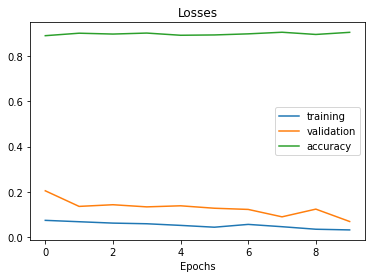

prediction comparison:

 tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  Tr

AttributeError: ignored

In [27]:
FFL.after_training_plots(train_loss, val_loss, train_acc)
X, y = next(iter(test_dl))
FFL.model_test(X, y, model)
FFL.torch.save(model.state_dict(), "/content/Learning/DenseNet_trained.pt")
import os
# Saving the last epoch of the train
save_dir = os.path.join('Second_CNN')
model.save(save_dir)
#model.load_state_dict(FFL.torch.load("/content/Learning/DenseNet_trained.pt"))